In [1]:
import numpy as np
import matplotlib.pyplot as plt
from asoh.models.ecm import ECMASOH, ECMInput
from asoh.models.ecm.simulator import ECMSimulator

In [2]:
# Define basic specifications for different models
specifications = {'rint': {'has_C0': False, 'num_RC': 0},
                  'thenevin': {'has_C0': False, 'num_RC': 1},
                  'pngv': {'has_C0': True, 'num_RC': 2}}

In [3]:
# Collect A-SOH templates
asoh_dict = {}
for model_name, specs in specifications.items():
    asoh_dict[model_name] = ECMASOH.provide_template(has_C0=specs['has_C0'], num_RC=specs['num_RC'])

Text(0.5, 0, 'SOC')

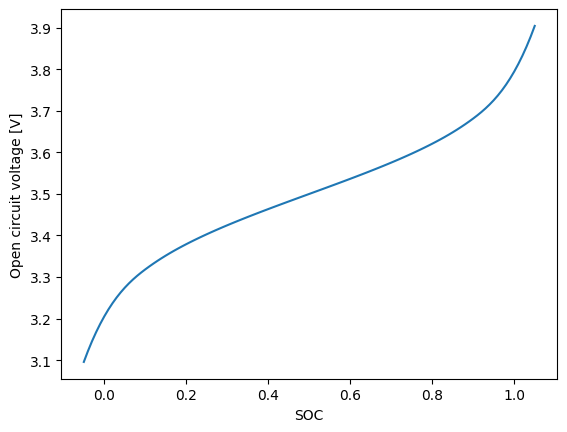

In [4]:
# They all use the same OCV; let's take a look at it
soc_vals = np.linspace(-0.05, 1.05, 111)
ocv = asoh_dict['rint'].ocv(soc=soc_vals)

plt.plot(soc_vals, ocv)
plt.ylabel('Open circuit voltage [V]')
plt.xlabel('SOC')

In [5]:
# Establish simulators
simulators = {}
for model_name, asoh in asoh_dict.items():
    simulators[model_name] = ECMSimulator(asoh, keep_history=True)

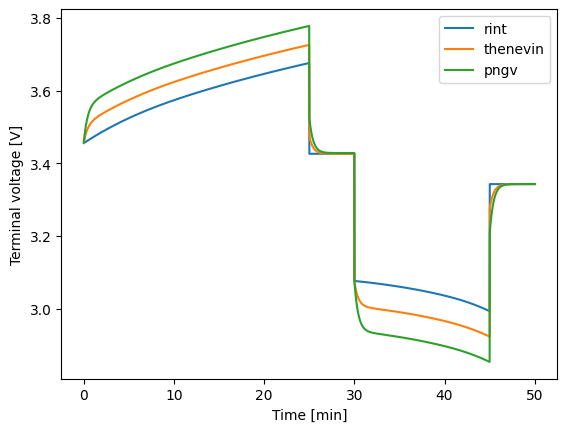

In [6]:
# Let's pretend we will charge the battery for 25 minutes with a current of 5 A,
# rest it for 5 minutes, discharge it for 15 minutes at a current of 7 A, and 
# finally rest it for another 2 minutes 
charge_time = 60 * 25
rest_time = 60 * 5
discharge_time = 60 * 15
timestamps = np.arange(charge_time + rest_time + discharge_time + rest_time) + 1
timestamps = timestamps.tolist()
currents = [5] * charge_time
currents += [0] * rest_time
currents += [-7] * discharge_time
currents += [0] * rest_time
# Prepare list of inputs
ecm_inputs = [ECMInput(time=time, current=current) \
              for (time, current) in zip(timestamps, currents)]

# Dictionary to store results
voltages = {}
for model_name, simulator in simulators.items():
    measurements = simulator.evolve(ecm_inputs)
    voltages[model_name] = [measure.terminal_voltage for measure in measurements]

# Now, plotting
timestamps = np.array(timestamps) / 60  # back to minutes
fig, ax = plt.subplots()
for model_name, volts in voltages.items():
    ax.plot(timestamps, volts, label=model_name)
ax.set_xlabel('Time [min]')
ax.set_ylabel('Terminal voltage [V]')
ax.legend()

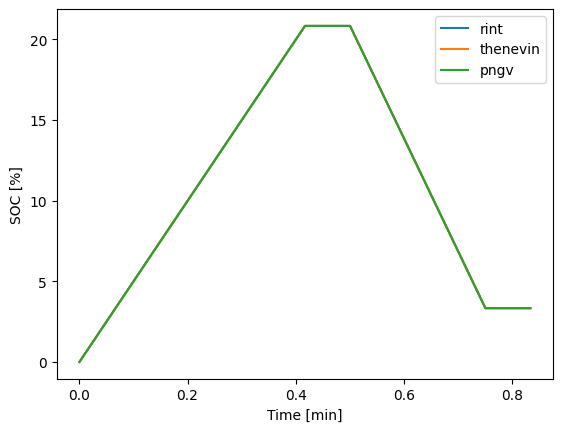

In [7]:
# Checking they all have the same SOC
SOCs = {}
for model_name, simulator in simulators.items():
    soc_vals = [transient.soc for transient in simulator.transient_history]
    SOCs[model_name] = soc_vals

# Plotting
timestamps = np.array(timestamps) / 60  # back to minutes
fig, ax = plt.subplots()
for model_name, soc_vals in SOCs.items():
    ax.plot(timestamps, 100 * np.array(soc_vals[1:]), label=model_name)
ax.set_xlabel('Time [min]')
ax.set_ylabel('SOC [%]')
ax.legend()